# **Deeplearnig Models Results**

In [ ]:
!mkdir /root/.kaggle

In [ ]:
#https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463
import json

token={"username":"onuragmaji2020","key":"1376199d74359e387137ac396c4fd796"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!kaggle datasets download -d authman/pickled-glove840b300d-for-10sec-loading

#!kaggle datasets download -d onuragmaji/lstmassignment    

100% 2.33G/2.33G [00:34<00:00, 44.4MB/s]
100% 2.33G/2.33G [00:34<00:00, 72.2MB/s]


In [ ]:
!kaggle datasets download -d onuragmaji2020/selfcasestudy1

 99% 1.26G/1.27G [00:13<00:00, 123MB/s]
100% 1.27G/1.27G [00:14<00:00, 97.3MB/s]


## **This sheet contains result of all deep learning Models trained using Jigshaw preprocessed data for deep learning Models.**

## We trained the DL models and preprocessed data in seprate notebooks

In [ ]:
from sklearn import model_selection
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.layers import Dense, Flatten, LSTM,GRU,Conv1D, MaxPooling1D, Dropout, Activation, Input,\
 Embedding,BatchNormalization,Bidirectional,GlobalMaxPool1D,concatenate,Reshape,GlobalAveragePooling1D
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json  
import json

from tensorflow.keras.utils import plot_model

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [ ]:
import zipfile
with zipfile.ZipFile("../content/pickled-glove840b300d-for-10sec-loading.zip", 'r') as zip_ref:
    zip_ref.extractall("../content/")

In [ ]:
with zipfile.ZipFile("../content/selfcasestudy1.zip", 'r') as zip_ref:
    zip_ref.extractall("../content/")

In [ ]:
import os
os.listdir("../content/")

['.config',
 'tokenizer_2_layer_lstm.pickle',
 'selfcasestudy1.zip',
 'tokenizer_bidirectional_lstm.pickle',
 'pickled-glove840b300d-for-10sec-loading.zip',
 'weights_stacking_deep_1.best.hdf5',
 'data_new.json',
 'weights_2_layer_cnn.best.hdf5',
 'weights_Dual_biDirectional_lstm.best.hdf5',
 'weights_cnn_lstm.best.hdf5',
 'glove.840B.300d.pkl',
 'tokenizer_lstm_gru.pickle',
 'tokenizer_cnn_lstm.pickle',
 'tokenizer_Dual_bidirectional.pickle',
 'tokenizer_stacking-deep_1.pickle',
 'weights_lstm_gru.best.hdf5',
 'weights_2_layer_lstm.best.hdf5',
 'weights_BIDIRECTIONAL_LSTM_Model.best.hdf5',
 'tokenizer_2_layer_CNN.pickle',
 'sample_data']

In [ ]:
GLOVE_EMBEDDING_PATH="../content/glove.840B.300d.pkl"
MAX_SEQUENCE_LENGTH = 250

In [ ]:
with open('../content/data_new.json', 'r') as fp:
    data = json.load(fp)  

## **Calculate the final score**

## **Evaluation Metric:**

Our goal to to reduce unintented bias as much as possible so we will use a special matric. 

we are refering the following information from <a href="https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation" target="_blank"><b>here</b></a>.

We will use metric that combines several submetrics to balance overall performance with various aspects of unintended bias.


<ol>
<li><b>Overall AUC</b><br>
   This is the ROC-AUC for the full evaluation set.</li><br><br>

<li><b>Bias AUCs</b><br>
   Here we calculate the ROC-AUC on three specific subsets of the test set for each identity, each capturing a different      aspect of unintended bias.<br><br>

<ol type="a"><li><b>Subgroup AUC:</b><br> 
       Here, we restrict the data set to only the examples that mention the specific identity subgroup. A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.</li><br>
<li><b>BPSN (Background Positive, Subgroup Negative) AUC:</b><br> 
       Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.</li><br>

<li><b>BNSP (Background Negative, Subgroup Positive) AUC:</b><br>
       Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.</li>
</li><br><br>

In [ ]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)


## Generalized Mean of Bias AUCs

To combine the per-identity Bias AUCs into one overall measure, we calculate their generalized mean as defined below:

$$M_p(m_s) = \left(\frac{1}{N} \sum_{s=1}^{N} m_s^p\right)^\frac{1}{p}$$


where: 

$$  M_p = the \ pth\ power\ mean\ function$$
$$m_s = the\ bias\ metric\ m \ calulated \ for \ subgroup$$
$$N = number \ of \ identity \ subgroups$$

## Final Metric

$$score = w_0 AUC_{overall} + \sum_{a=1}^{A} w_a M_p(m_{s,a})$$

where:

$$A = number \ of \ submetrics \ (3)$$

$$m_{s,a} = bias \ metric \ for \ identity \ subgroup \ s \ using \ submetric \ a$$

$$w_a = a \ weighting \ for \ the \ relative \ importance \ of \ each \ submetric; \ all \ four \ w \ values \ set \ to \ 0.25$$

In [ ]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
#get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))

 # **1. Using 2 layers LSTM Model**

In [ ]:
import pickle

# saving
#with open('tokenizer_cnn_lstm.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle)

# loading
with open('../content/tokenizer_2_layer_lstm.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
EMBEDDINGS_DIMENSION = 300
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  199918


In [ ]:
def simple_LSTM():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name='inputs')
    #inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                        EMBEDDINGS_DIMENSION,
                                        #weights=[embedding_matrix],
                                        weights=[glove_matrix],  
                                        input_length=MAX_SEQUENCE_LENGTH,
                                        trainable=False)
    layer = embedding_layer(sequence_input)
    layer = LSTM(256,return_sequences=True)(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)

    layer = Dropout(0.5)(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)

    model = Model(inputs=sequence_input,outputs=layer)
    return model

In [ ]:

LSTM_Model_load = simple_LSTM()
LSTM_Model_load.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
LSTM_Model_load.load_weights("../content/weights_2_layer_lstm.best.hdf5")
LSTM_Model_load.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 300)          105759000 
_________________________________________________________________
lstm (LSTM)                  (None, 250, 256)          570368    
_________________________________________________________________
dropout (Dropout)            (None, 250, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation (Activation)      (None, 256)               0     

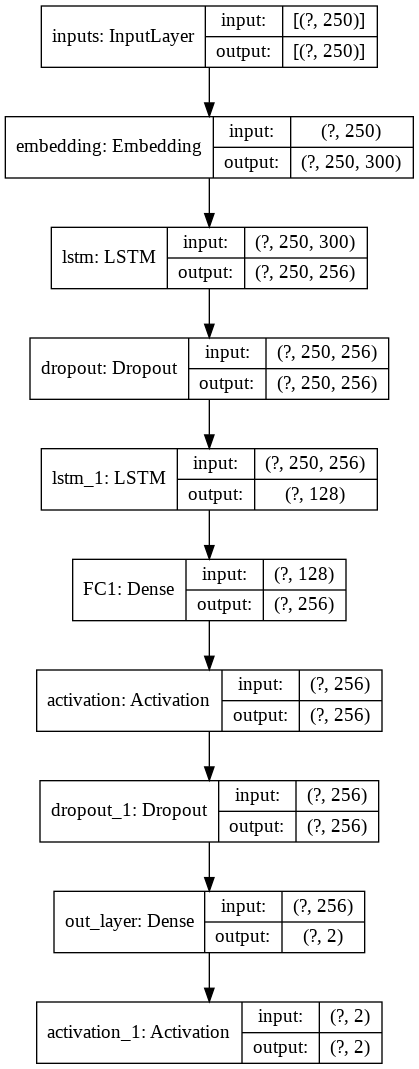

In [ ]:
plot_model(LSTM_Model_load, 'model_LSTM.png', show_shapes=True)

## **After Trainning the Model for 40 Epochs**


## Loss and Accuracy Plots

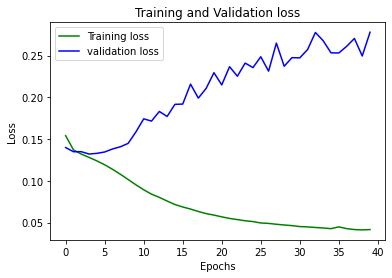

In [ ]:
loss_train = data["LSTM_1_40"]['loss']
loss_val = data["LSTM_1_40"]['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

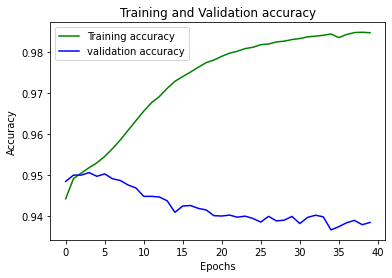

In [ ]:
loss_train = data["LSTM_1_40"]['accuracy']
loss_val = data["LSTM_1_40"]['val_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **AUC Score on Test Data is 0.98898**
## **Evaluation Metric Score on Test Data is 0.98339**
## **Kaggle Score for submission test file on Private leaderboard: 0.86595**<br>
<img src="https://i.ibb.co/B3qCS0D/lstm-2-layer.png" alt="lstm-2-layer" border="0">

In [ ]:
import gc
del glove_matrix
del LSTM_Model_load
gc.collect()

6615

 # **2. Using 2 layers CNN 1D**

In [ ]:
with open('../content/tokenizer_2_layer_CNN.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


EMBEDDINGS_DIMENSION = 300
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  200094


In [ ]:
def CNN_Model_get():
        """Returns (input_layer, output_layer)"""
        input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[glove_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(input)
        x = Conv1D(128, 2, activation='relu', padding='same')(x)
        #x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 4, activation='relu', padding='same')(x)
        x = MaxPooling1D(40, padding='same')(x)
        x = Flatten()(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs=input,outputs=output)
        return model

In [ ]:

CNN_Model_load = CNN_Model_get()
CNN_Model_load.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
CNN_Model_load.load_weights("../content/weights_2_layer_cnn.best.hdf5")
CNN_Model_load.summary() 


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 300)          105859200 
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 128)          76928     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           65664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0   

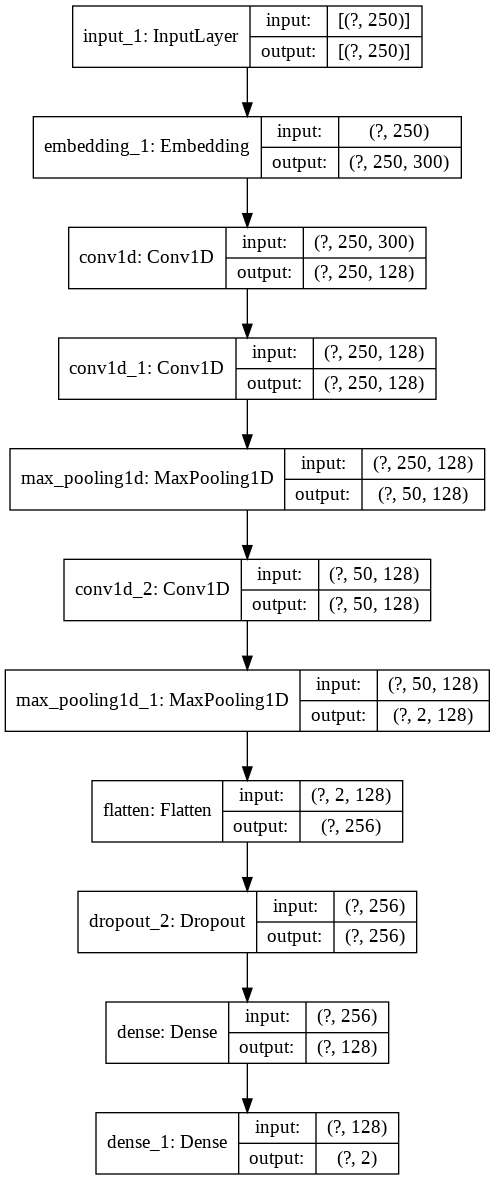

In [ ]:

plot_model(CNN_Model_load, 'model_CNN.png', show_shapes=True)

## **After Trainning the Model for 40 Epochs**


## Loss and Accuracy Plots

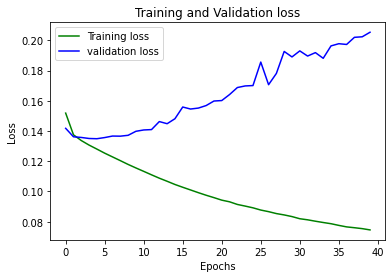

In [ ]:
loss_train = data["CNN_1_40"]['loss']
loss_val = data["CNN_1_40"]['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

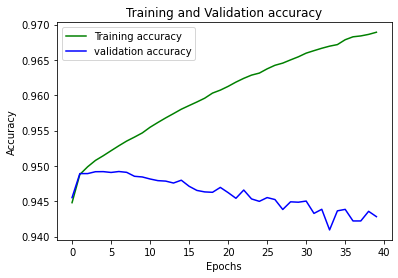

In [ ]:
loss_train = data["CNN_1_40"]['accuracy']
loss_val = data["CNN_1_40"]['val_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **AUC Score on Test Data is 0.9823**
## **Evaluation Metric Score on Test Data is 0.9715**
## **Kaggle Score for submission test file on Private leaderboard: 0.86595**<br>
<img src="https://i.ibb.co/XYVgrmW/cnn-2-layer.png" alt="cnn-2-layer" border="0">

In [ ]:
del glove_matrix
del CNN_Model_load
gc.collect()

6858

 # **3. Using Bidirectional LSTM**

In [ ]:
with open('../content/tokenizer_bidirectional_lstm.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


EMBEDDINGS_DIMENSION = 300
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  199700


In [ ]:
def Bidirectional_LSTM():
    input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name='inputs')
    #inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                        EMBEDDINGS_DIMENSION,
                                        #weights=[embedding_matrix],
                                        weights=[glove_matrix],  
                                        input_length=MAX_SEQUENCE_LENGTH,
                                        trainable=False)
    layer = embedding_layer(input)
    layer = Bidirectional(LSTM(128,return_sequences=True))(layer)
    layer = Dropout(0.3)(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(512,activation='relu',name='FC1')(layer) 
    layer = BatchNormalization()(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)

    model = Model(inputs=input,outputs=layer)
    return model

In [ ]:
model_Bidirectional_LSTM = Bidirectional_LSTM()
model_Bidirectional_LSTM.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_Bidirectional_LSTM.load_weights("../content/weights_BIDIRECTIONAL_LSTM_Model.best.hdf5")
model_Bidirectional_LSTM.summary() 



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 250)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 250, 300)          105687300 
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 256)          439296    
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 256)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0   

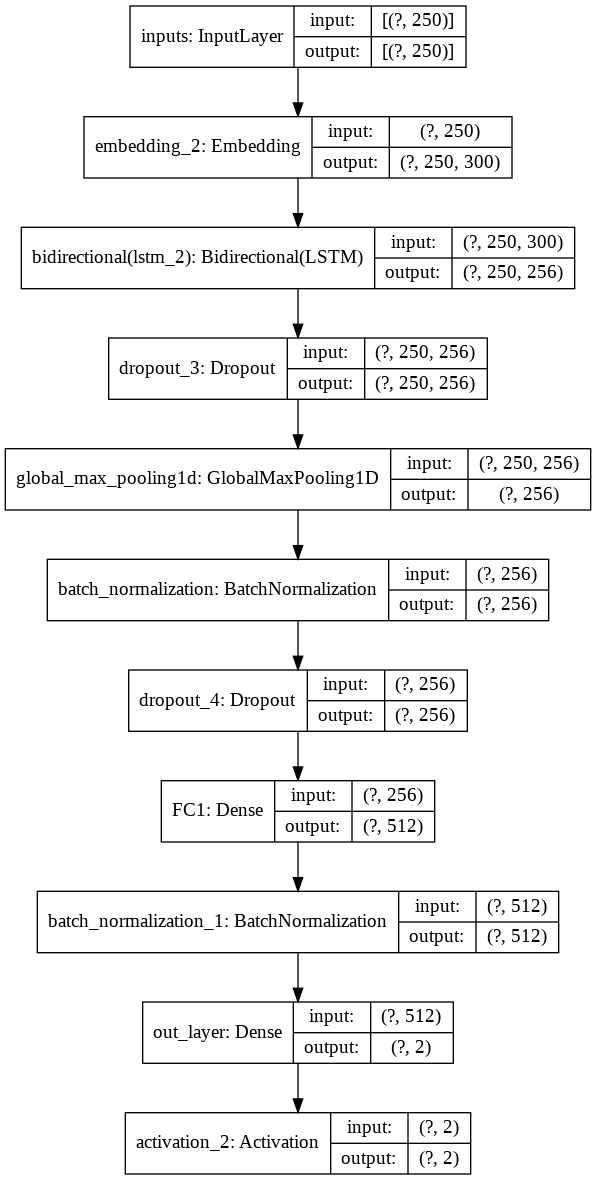

In [ ]:
plot_model(model_Bidirectional_LSTM, 'model_Bidirectional_LSTM.png', show_shapes=True)

## **After Trainning the Model for 40 Epochs**


## Loss and Accuracy Plots

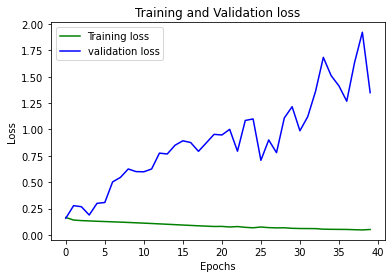

In [ ]:
loss_train = data["Bidirectional_LSTM_40"]['loss']
loss_val = data["Bidirectional_LSTM_40"]['val_loss']
#epochs = np.range(1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

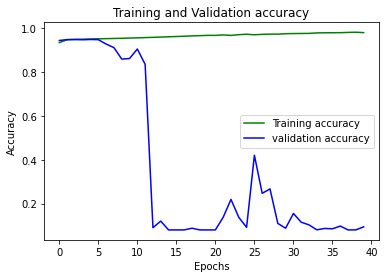

In [ ]:
loss_train = data["Bidirectional_LSTM_40"]['accuracy']
loss_val = data["Bidirectional_LSTM_40"]['val_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **AUC Score on Test Data is 0.96079**
## **Evaluation Metric Score on Test Data is 0.95825**
## **Kaggle Score for submission test file on Private leaderboard: 0.81030**<br>
<img src="https://i.ibb.co/6g6pNjk/bidirectional-lstm.png" alt="bidirectional-lstm" border="0">


In [ ]:
del glove_matrix
del model_Bidirectional_LSTM
gc.collect()

8904

 # **4. Using Dual Bidirectional LSTM**

In [ ]:
with open('../content/tokenizer_Dual_bidirectional.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


EMBEDDINGS_DIMENSION = 300
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  200149


In [ ]:
def Dual_Bidirectional_LSTM():
    input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name='inputs')
    #inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                        EMBEDDINGS_DIMENSION,
                                        #weights=[embedding_matrix],
                                        weights=[glove_matrix],  
                                        input_length=MAX_SEQUENCE_LENGTH,
                                        trainable=False)
    layer1 = embedding_layer(input)
    layer1 = Bidirectional(LSTM(128,return_sequences=True))(layer1)
    layer1 = Dropout(0.3)(layer1)
    layer1 = GlobalMaxPool1D()(layer1)
     
    layer2 = embedding_layer(input)
    layer2 = Bidirectional(LSTM(128,return_sequences=True))(layer2)
    layer2 = Dropout(0.3)(layer2)
    layer2 = GlobalMaxPool1D()(layer2)
 

    layer = concatenate([layer1, layer2])
    layer = Dense(256,activation='relu',name='FC1')(layer) 
    layer = BatchNormalization()(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)

    model = Model(inputs=input,outputs=layer)
    return model

In [ ]:
model_Bidirectional_LSTM = Dual_Bidirectional_LSTM()
model_Bidirectional_LSTM.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_Bidirectional_LSTM.load_weights("../content/weights_Dual_biDirectional_lstm.best.hdf5")
model_Bidirectional_LSTM.summary() 


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 250, 300)     105847200   inputs[0][0]                     
                                                                 inputs[0][0]                     
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 250, 256)     439296      embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 250, 256)     439296      embedding_3[1][0]          

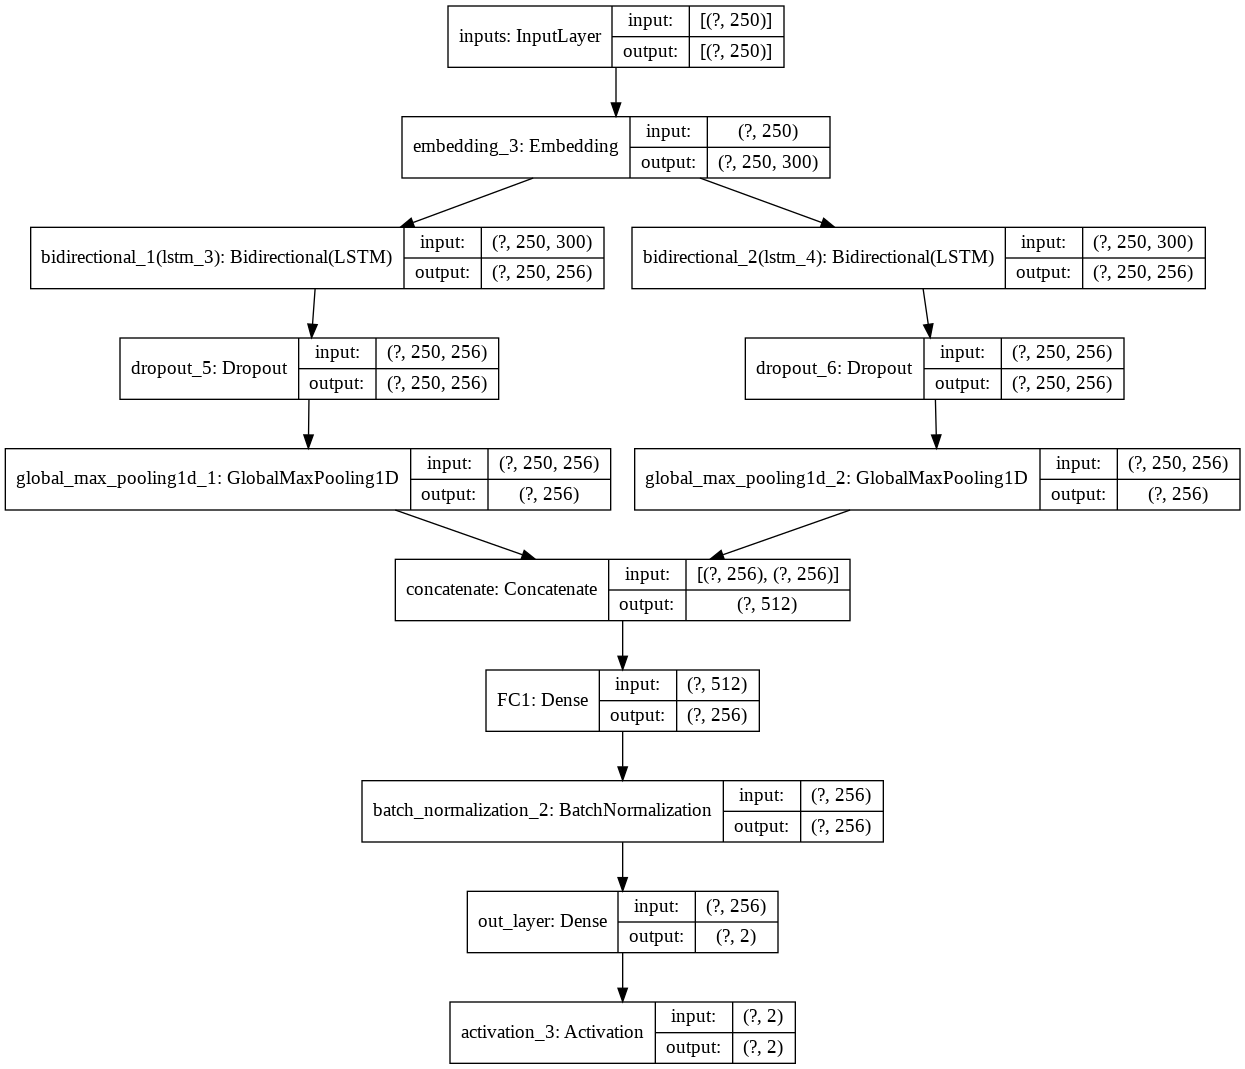

In [ ]:
plot_model(model_Bidirectional_LSTM, 'model_Bidirectional_LSTM.png', show_shapes=True)

## **After Trainning the Model for 30 Epochs**


## Loss and Accuracy Plots

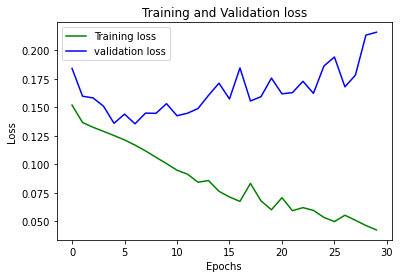

In [ ]:
loss_train = data["Dual_Bidirectional_LSTM_30"]['loss']
loss_val = data["Dual_Bidirectional_LSTM_30"]['val_loss']
#epochs = np.range(1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

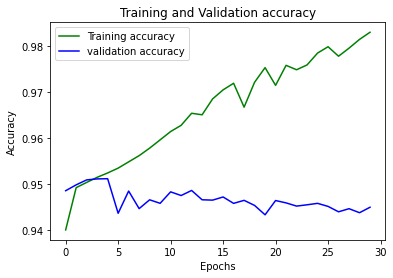

In [ ]:


loss_train = data["Dual_Bidirectional_LSTM_30"]['accuracy']
loss_val = data["Dual_Bidirectional_LSTM_30"]['val_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## **AUC Score on Test Data is 0.9876**
## **Evaluation Metric Score on Test Data is0.98012**
## **Kaggle Score for submission test file on Private leaderboard: 0.85731**
<img src="https://i.ibb.co/Z8pm2J9/dual-bidirectional-lstm.png" alt="dual-bidirectional-lstm" border="0">

In [1]:
del glove_matrix
del model_Bidirectional_LSTM
gc.collect()

NameError: ignored

 # **5. Using CNN LSTM Model**

In [ ]:
with open('../content/tokenizer_cnn_lstm.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


EMBEDDINGS_DIMENSION = 300
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  199961


In [ ]:
def CNN_LSTM_model():
    #model_conv = Sequential()
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name='inputs')
    embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                        EMBEDDINGS_DIMENSION,
                                        #weights=[embedding_matrix],
                                        weights=[glove_matrix],  
                                        input_length=MAX_SEQUENCE_LENGTH,
                                        trainable=False)
    layer1 = embedding_layer(sequence_input)
    layer1 = LSTM(512,return_sequences=True)(layer1)
    #layer1 = Dropout(0.3)(layer1)
    
    layer1 = LSTM(256,return_sequences=True)(layer1)
    layer1 = Dropout(0.2)(layer1)
    
    layer1 = LSTM(128,return_sequences=True)(layer1)
    layer1 = Dropout(0.2)(layer1)
    
    layer1 = BatchNormalization()(layer1)
    layer1 = Flatten()(layer1)
    layer1 = Dense(128,name='FC1')(layer1)
    layer1 = Activation('relu')(layer1)
    
    
    
    
    layer2 = embedding_layer(sequence_input)
    layer2 = Conv1D(256, 2, activation='relu', padding='same')(layer2)
    layer2 = Conv1D(128, 3, activation='relu', padding='same')(layer2)
    #layer2 = MaxPooling1D(5, padding='same')(layer2)
    layer2 = Conv1D(128, 4, activation='relu', padding='same')(layer2)
    layer2 = MaxPooling1D(10, padding='same')(layer2)
    layer2 = BatchNormalization()(layer2)
    layer2 = Flatten()(layer2)
    layer2 = Dropout(0.3)(layer2)
    layer2 = Dense(128, activation='relu')(layer2)
    #output = Dense(2, activation='softmalayer2')(layer2)

    layer = concatenate([layer1, layer2])
    layer = Dense(256,activation='relu',name='FC2')(layer) 
    layer = Dropout(0.2)(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    

    model = Model(inputs=sequence_input,outputs=layer)
    

    return model

In [ ]:

model_LSTM_CNN = CNN_LSTM_model()
model_LSTM_CNN.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_LSTM_CNN.load_weights("../content/weights_cnn_lstm.best.hdf5")
model_LSTM_CNN.summary() 


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 250, 300)     105733500   inputs[0][0]                     
                                                                 inputs[0][0]                     
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 250, 512)     1665024     embedding_4[0][0]                
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 250, 256)     787456      lstm_5[0][0]               

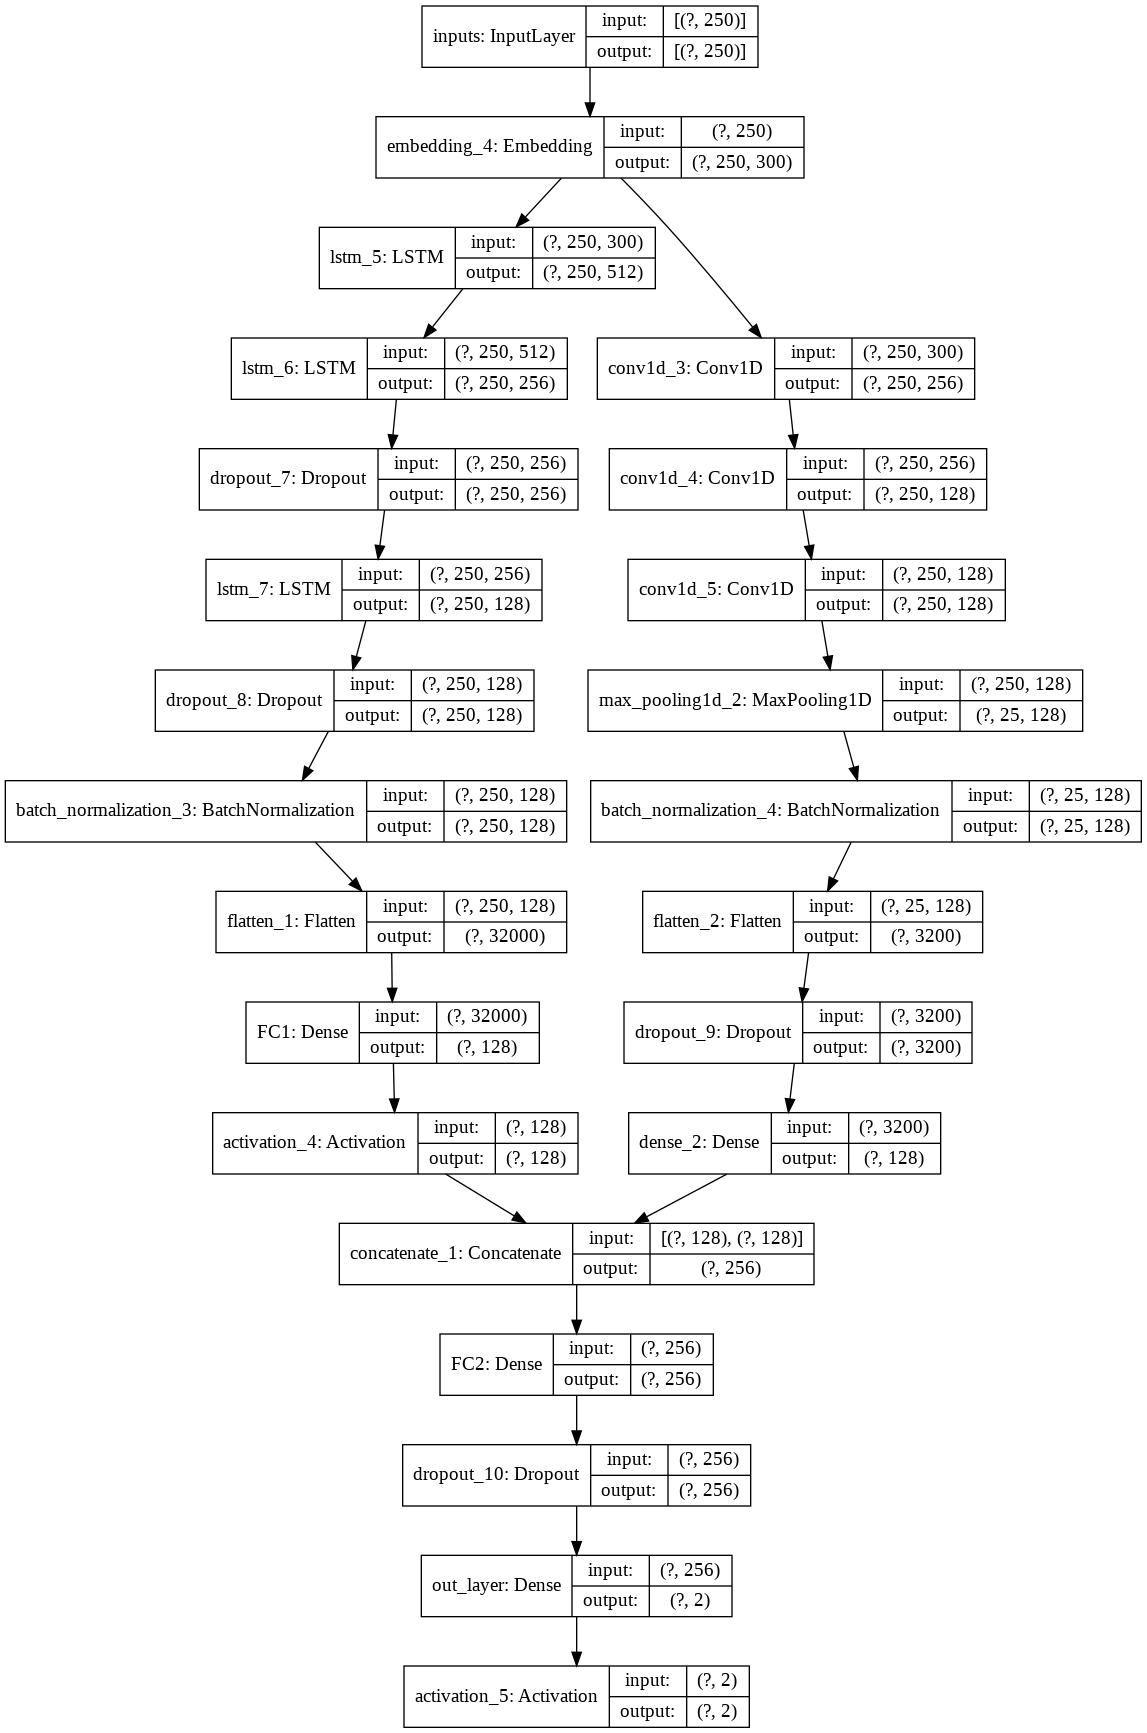

In [ ]:

plot_model(model_LSTM_CNN, 'model_CNN_LSTM.png', show_shapes=True)

## **After Trainning the Model for 30 Epochs**


## Loss and Accuracy Plots

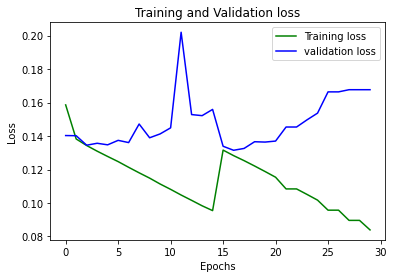

In [ ]:
loss_train = data["CNN_LSTM"]['loss']
loss_val = data["CNN_LSTM"]['val_loss']
#epochs = np.range(1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

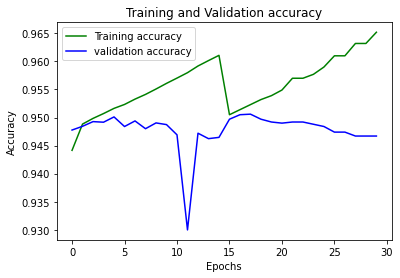

In [ ]:
loss_train = data["CNN_LSTM"]['accuracy']
loss_val = data["CNN_LSTM"]['val_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **AUC Score on Test Data is 0.9796166**
## **Evaluation Metric Score on Test Data is 0.95944060**
## **Kaggle Score for submission test file on Private leaderboard: 0.88755**
<img src="https://i.ibb.co/x2b0B6Z/cnn-lstm.png" alt="cnn-lstm" border="0">


In [ ]:
del glove_matrix
del model_LSTM_CNN
gc.collect()

10250

# **6. Stacking Models**

## Stacking Some of the Models with more than 85% Kaggle Private leaderboard Score

In [ ]:
with open('../content/tokenizer_stacking-deep_1.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


EMBEDDINGS_DIMENSION = 300
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  200000


In [ ]:
def stacking_model():
    
    input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32',name='inputs')
    embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                        EMBEDDINGS_DIMENSION,
                                        weights=[glove_matrix],  
                                        input_length=MAX_SEQUENCE_LENGTH,
                                        trainable=False)
    layer1 = embedding_layer(input)
    layer1 = LSTM(256,return_sequences=True)(layer1)
    layer1 = Dropout(0.5)(layer1)
    layer1 = LSTM(128)(layer1)
    layer1 = Dropout(0.3)(layer1)
    
    
    layer2 = embedding_layer(input)
    layer2 = Conv1D(128, 2, activation='relu', padding='same')(layer2)
    layer2 = MaxPooling1D(5, padding='same')(layer2)
    layer2 = Conv1D(128, 3, activation='relu', padding='same')(layer2)
    layer2 = MaxPooling1D(5, padding='same')(layer2)
    layer2 = Conv1D(128, 4, activation='relu', padding='same')(layer2)
    layer2 = MaxPooling1D(40, padding='same')(layer2)
    layer2 = Flatten()(layer2)
    layer2 = Dropout(0.3)(layer2)
    layer2 = Dense(128, activation='relu')(layer2)
    
    
    layer3 = embedding_layer(input)
    layer3 = Bidirectional(LSTM(128,return_sequences=True))(layer3)
    layer3 = Dropout(0.3)(layer3)
    layer3 = GlobalMaxPool1D()(layer3)
    layer3 = BatchNormalization()(layer3)
    layer3 = Dropout(0.5)(layer3)
    layer3 = Dense(128, activation='relu')(layer3)
    
    
    
    layer = concatenate([layer1, layer2, layer3])
    layer = Dense(256,activation='relu',name='FC1')(layer) 
    layer = BatchNormalization()(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)

    model = Model(inputs=input,outputs=layer)

 
    return model

In [ ]:

stacking_model_1 = stacking_model()
stacking_model_1.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
stacking_model_1.load_weights("../content/weights_stacking_deep_1.best.hdf5")
stacking_model_1.summary() 


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 250, 300)     105802500   inputs[0][0]                     
                                                                 inputs[0][0]                     
                                                                 inputs[0][0]                     
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 250, 128)     76928       embedding_5[1][0]                
____________________________________________________________________________________________

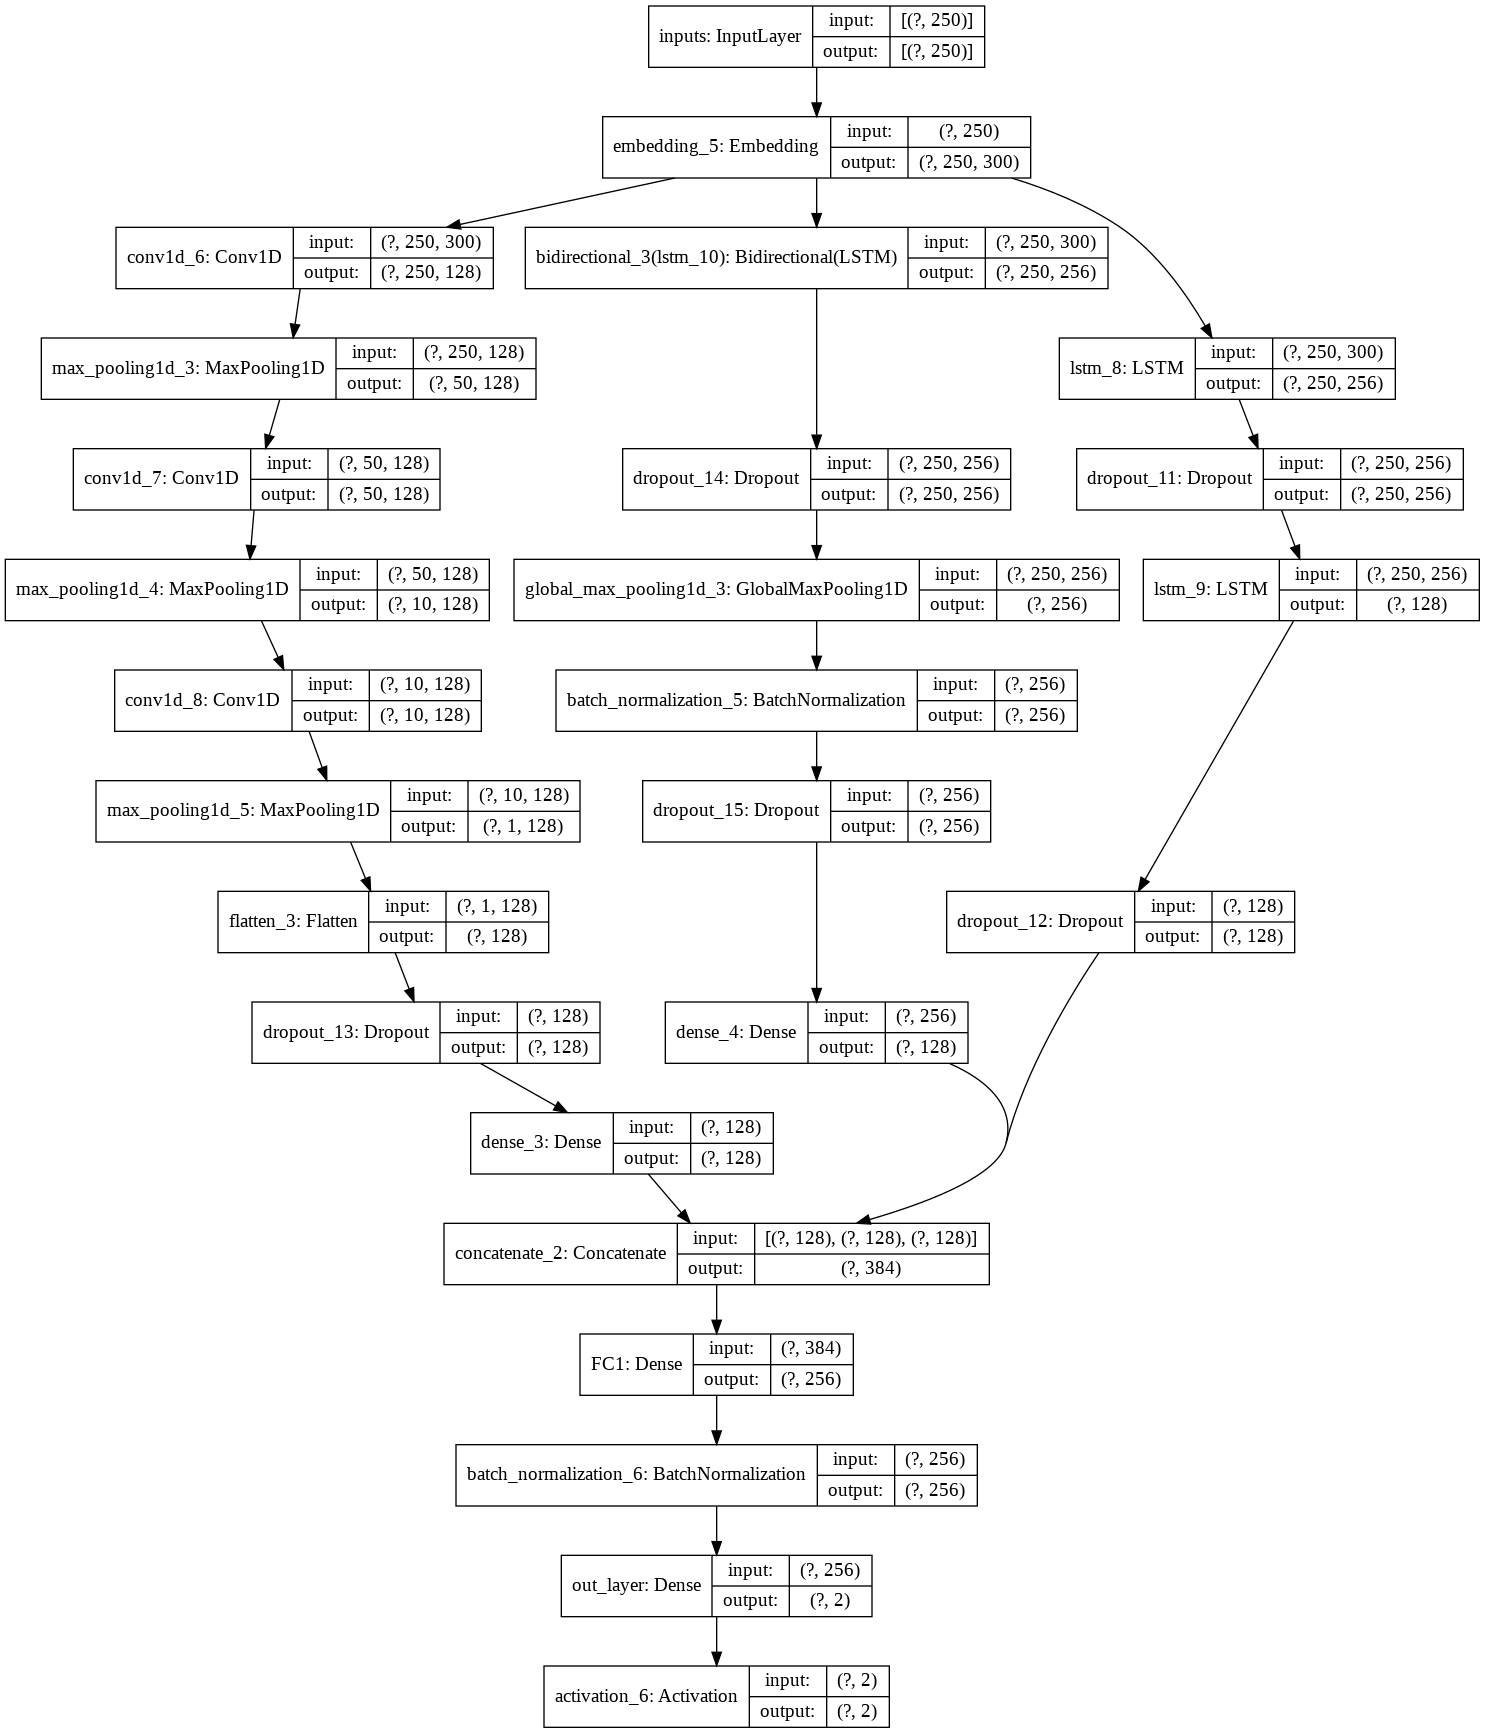

In [ ]:
plot_model(stacking_model_1, 'stacking_model_1.png', show_shapes=True)

## **After Trainning the Model for 20 Epochs**


## Loss and Accuracy Plots

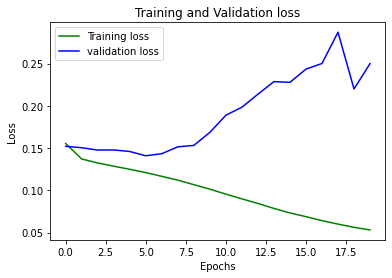

In [ ]:
loss_train = data["Stacking_1_20"]['loss']
loss_val = data["Stacking_1_20"]['val_loss']
#epochs = np.range(1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

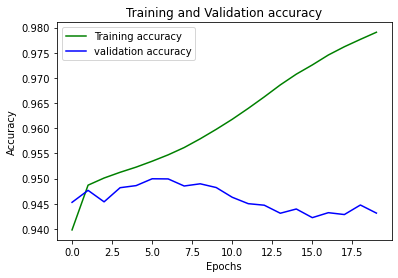

In [ ]:
loss_train = data["Stacking_1_20"]['accuracy']
loss_val = data["Stacking_1_20"]['val_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **AUC Score on Test Data is 0.98094205**
## **Evaluation Metric Score on Test Data is 0.9692197**
## **Kaggle Score for submission test file on Private leaderboard: 0.84741**<img src="https://i.ibb.co/F5QLCLf/Stacking-1.png" alt="Stacking-1" border="0">

In [ ]:
del glove_matrix
del stacking_model_1
gc.collect()

10720

# **7. LSTM GRU**

In [ ]:
with open('../content/tokenizer_lstm_gru.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


EMBEDDINGS_DIMENSION = 300
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  200115


In [ ]:
#https://stackoverflow.com/questions/56918388/error-valueerror-the-last-dimension-of-the-inputs-to-dense-should-be-defined


def LSTM_GRU_model():
    #model_conv = Sequential()
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name='inputs')
    embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                        EMBEDDINGS_DIMENSION,
                                        #weights=[embedding_matrix],
                                        weights=[glove_matrix],  
                                        input_length=MAX_SEQUENCE_LENGTH,
                                        trainable=False)
    
    
    
    layer1 = embedding_layer(sequence_input)
    
    layer1 = Dropout(0.2)(layer1)
    layer1 = Bidirectional(LSTM(120, return_sequences=True))(layer1)
    layer1, fowrward_h_state, backward_h_state = Bidirectional(GRU(60, return_sequences= True, return_state=True))(layer1)
    
    
    
    h_state = concatenate([fowrward_h_state, backward_h_state])
    h_state = Reshape((-1,120))(h_state )

    h_avg = GlobalAveragePooling1D()(layer1)
    h_max = GlobalMaxPool1D()(layer1)

    h_avg = Reshape((-1,120))(h_avg)
    h_max = Reshape((-1,120))(h_max)
    
    
    
    x = concatenate([h_state, h_avg, h_max])
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.1)(x)
    #https://stackoverflow.com/questions/56918388/error-valueerror-the-last-dimension-of-the-inputs-to-dense-should-be-defined
    x = GlobalMaxPool1D()(x)
    
    
    output = Dense(2, activation='sigmoid')(x)
    model = Model(inputs=sequence_input, outputs = output)
    
    
    

    return model

In [ ]:
LSTM_GRU_model_1 = LSTM_GRU_model()
LSTM_GRU_model_1.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
LSTM_GRU_model_1.load_weights("../content/weights_lstm_gru.best.hdf5")
LSTM_GRU_model_1.summary() 

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 250, 300)     105834300   inputs[0][0]                     
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 250, 300)     0           embedding_6[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 250, 240)     404160      dropout_16[0][0]                 
____________________________________________________________________________________________

## **After Trainning the Model for 20 Epochs**


## Loss and Accuracy Plots

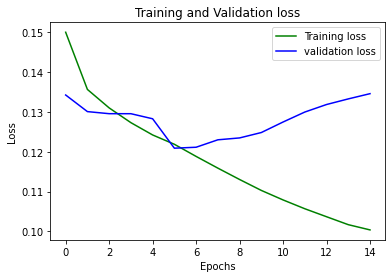

In [ ]:
loss_train = data["LSTM_GRU"]['loss']
loss_val = data["LSTM_GRU"]['val_loss']
#epochs = np.range(1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

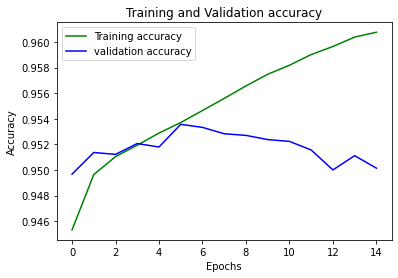

In [ ]:
loss_train = data["LSTM_GRU"]['accuracy']
loss_val = data["LSTM_GRU"]['val_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **AUC Score on Test Data is 0.979908375**
## **Evaluation Metric Score on Test Data is 0.9592632**
## **Kaggle Score for submission test file on Private leaderboard: 0.90735**
<img src="https://i.ibb.co/DG0pXTb/GRU-LSTM.png" alt="GRU-LSTM" border="0">

In [6]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Test AUC Score", "Test Eval Metric score", "Kaggle Score"]

x.add_row(["2 layers CNN 1D", 0.9890, 0.9834, 0.8660])
x.add_row(["2 layers LSTM", 0.9823, 0.9715, 0.8660])
x.add_row(["Bidirectional LSTM", 0.9608, 0.9583, 0.8103])
x.add_row(["Dual Bidirectional LSTM", 0.9876, 0.9801,0.8573])
x.add_row(["CNN LSTM Model", 0.9796, 0.9594, 0.8876])
x.add_row(["Stacked Model", 0.9809, 0.9692, 0.8474])
x.add_row(["LSTM GRU", 0.9799, 0.9593, 0.9074])

print(x)

+-------------------------+----------------+------------------------+--------------+
|          Model          | Test AUC Score | Test Eval Metric score | Kaggle Score |
+-------------------------+----------------+------------------------+--------------+
|     2 layers CNN 1D     |     0.989      |         0.9834         |    0.866     |
|      2 layers LSTM      |     0.9823     |         0.9715         |    0.866     |
|    Bidirectional LSTM   |     0.9608     |         0.9583         |    0.8103    |
| Dual Bidirectional LSTM |     0.9876     |         0.9801         |    0.8573    |
|      CNN LSTM Model     |     0.9796     |         0.9594         |    0.8876    |
|      Stacked Model      |     0.9809     |         0.9692         |    0.8474    |
|         LSTM GRU        |     0.9799     |         0.9593         |    0.9074    |
+-------------------------+----------------+------------------------+--------------+
